In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import minimize
from nodepy import rk
from IPython.display import clear_output
import sys




rk44 = rk.loadRKM('RK44').__num__()





In [2]:
colors = ['#E69F00', '#56B4E9', '#009E73', '#0072B2', '#D55E00', '#CC79A7', '#F0E442']
#linestyles = ['-', '--', '-.', ':', "-", "--", "-."]
linestyles = ['-', '--', '-.', ':', (5, (10, 3)),(0, (3, 1, 1, 1))]
markers = ['o','D','X','s','v',"P"]


font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 25}

import matplotlib
matplotlib.rc('font', **font)

#plt.rc("text", usetex=True)
plt.rc("legend", fontsize="medium", fancybox=True, framealpha=0.5)

plt.rcParams["mathtext.fontset"] = "cm"

In [3]:


def G_1(u):
    
    return 0.5*np.dot(u,u)

def dG_1(u):
    return u




def rgam(gamma,u,inc1,E1_old, est):
    gamma1 = gamma
    uprop = u + gamma1*inc1 
    E1 = G_1(uprop)

    return E1-E1_old - (gamma1+1)*est
    

def rgam_RF(eps,dt, u_tilde, search1, E1_old, est):
    
    
    uprop = u_tilde + dt* eps* search1 
    E1 = G_1(uprop)

    return E1-E1_old - est


def proj_distance(k_0, s, F, dt, u_tilde, E1_old, est):

    no_inv = 1; eps0 = 0.1
    
    
    k_01= k_0.copy()
    

    search_01= sum([k_01[i]*F[i] for i in range(s)])/np.linalg.norm(sum([k_01[i]*F[i,:] for i in range(s)]))
    #search_02= sum([k_02[i]*F[i] for i in range(s)])/np.linalg.norm(sum([k_02[i]*F[i,:] for i in range(s)]))

    eps, info, ier, mesg = fsolve(rgam_RF,eps0,args=(dt, u_tilde,search_01,E1_old, est),full_output=True)
    #print('mesg: ', mesg)
 

    distance= np.linalg.norm(dt*eps* search_01 )
    #print('distance_opt: ', distance)
    #print('k_1 optimized: ', k_01)
    #print('k_2 optimized: ', k_02)
    return distance

    

def Angle_between(k, s, F, V2):

    k= k/ np.linalg.norm(k)

    
    V1= sum([k[i]*F[i] for i in range(s)])/np.linalg.norm(sum([k[i]*F[i,:] for i in range(s)]))


    
    V2= V2/np.linalg.norm(V2)

    deg= (180/np.pi)* np.arccos(np.dot(V1, V2))

    #print('k_opt: ', k)
    #print('deg_opt: ', deg)

    return deg




In [4]:
def project_direction(u, F):
    s= np.size(F[:, 0])
    n= np.size(F[0, :])

    Normals= np.zeros((1, n))




    for i in range(s):
        normal = F[i , :].copy()
        for j in range(np.size( Normals[:, 0] )):

            normal -= np.dot(normal, Normals[j, :])* Normals[j, :]

        
        
        if np.linalg.norm(normal) > 1.e-7:
            normal= normal / np.linalg.norm(normal)

            Normals= np.append(Normals, np.reshape(normal.copy(), (1,len(normal))), axis=0)
            

    
    
    #print('Normals: ', Normals)
    
    u_projected= np.zeros(n)
    for i in range(np.size( Normals[:, 0] )):
        #print('dot(u, Normals): ',np.dot(u, Normals[i, :]))
        u_projected += np.dot(u, Normals[i, :])* Normals[i, :]

    #print('optimized deg:', (180/np.pi)* np.arccos(np.dot(u, u_projected)/ (np.linalg.norm(u)* np.linalg.norm(u_projected))))

    return u_projected

# Baseline RK

In [5]:
# Compute solution with baseline RK methods
def compute_sol_without_relaxation(Mthdname,rkm, dt, f, T, u0,t0, n_lim): 
    tt = np.zeros(1) 
    t = t0; tt[0] = t
    uu = np.zeros((1,np.size(u0))) 
    uu[0,:] = u0.copy()
    
    s = len(rkm)
    y = np.zeros((s,len(u0))) 
    F = np.zeros((s,len(u0))) 
    steps = 0

    n= 0
    
    while t < T and not np.isclose(t, T,  rtol=1e-12, atol=1e-12) and n<n_lim:
    #while t < T and not n > 0:
        n+=1
        clear_output(wait=True)
        if t + dt > T:
            dt = T - t
        for i in range(s):
            y[i,:] = uu[-1].copy()
            for j in range(i):
                y[i,:] += dt*rkm.A[i,j]*F[j,:]
            F[i,:] = f(y[i,:])
        inc = dt*sum([rkm.b[i]*F[i] for i in range(s)])    
        unew = uu[-1]+inc; t+= dt
        tt = np.append(tt, t)
        steps +=1
        uu = np.append(uu, np.reshape(unew.copy(), (1,len(unew))), axis=0)  
        #print("Method = Baseline %s: Step number = %d (time = %1.2f)"%(Mthdname,steps,tt[-1]))
    return tt, uu

# RRK

In [6]:
def compute_relaxation(Mthdname,rkm, dt, f, T, u0, t0, n_lim):
    tt = np.zeros(1) 
    t = t0; tt[0] = t
    uu = np.zeros((1,np.size(u0))) 
    uu[0,:] = u0.copy()
    
    s = len(rkm)
    y = np.zeros((s,len(u0))) 
    F = np.zeros((s,len(u0))) 
    
    Gamma = np.array([]); 
    no_inv = 1; gamma0 = 1
    Inv1_change= np.array([]); 

   
    
    errs = 0; steps = 0

    n=0 #test

    
    
    while t < T and not np.isclose(t, T,  rtol=1e-12, atol=1e-12) and n< n_lim: 
    #while t < T and not n > 0:

        n+=1 #test
        clear_output(wait=True)
        if t + dt > T:
            dt = T - t
        for i in range(s):
            y[i,:] = uu[-1].copy()
            for j in range(i):
                y[i,:] += dt*rkm.A[i,j]*F[j,:]
            F[i,:] = f(y[i,:])
            
        inc1 = dt*sum([rkm.b[i]*F[i] for i in range(s)])

        est= dt* sum(rkm.b[i]*np.dot(y[i], F[i]) for i in range(s) )
        #print('est: ', est)
       
        
        wr_unew = uu[-1] + inc1; E1_old = G_1(uu[-1]) 
        
        gamma, info, ier, mesg = fsolve(rgam,gamma0,args=(wr_unew,inc1,E1_old, est),full_output=True)

       
        #print('gamma: ',gamma)

        
        

        
    
        
        

        numer = 2 * sum(rkm.b[i] * rkm.A[i, j] * np.dot(F[i], F[j]) \
                            for i in range(s) for j in range(s))
        
        denom = sum(rkm.b[i] * rkm.b[j] * np.dot(F[i], F[j]) for i in range(s) for j in range(s))

        #print('numer: ', numer)
        #print('denom: ', denom)

        gam = numer / denom -1
        #print('1+gam: ', 1+gam)

        gamma1= gam



      



        
        
        unew =  wr_unew + gamma1*inc1 ; t+=(1+gamma1)*dt
        E1_new= G_1(unew)
       
        tt = np.append(tt, t)
        steps += 1
        uu = np.append(uu, np.reshape(unew.copy(), (1,len(unew))), axis=0) 
        Gamma = np.append(Gamma, gamma1);

        Inv1_change= np.append(Inv1_change, E1_new-E1_old) ; 
        
        #print("Method = Relaxation %s: At step number = %d (time = %1.2f), integer flag = %d and E1-E1_old = %f \n"%(Mthdname,steps,tt[-1],ier,E1_new-E1_old))

    return tt, uu, Gamma,  Inv1_change

# QO_RK

In [7]:
def compute_sol_QO(Mthdname,rkm, dt, f, T, u0, t0, n_lim):
    tt = np.zeros(1) 
    t = t0; tt[0] = t
    uu = np.zeros((1,np.size(u0))) 
    uu[0,:] = u0.copy()
    u = np.array(u0)
    
    s = len(rkm)
    y = np.zeros((s,len(u0))) 
    F = np.zeros((s,len(u0))) 
    b= rkm.b


    
    Eps1 = np.array([]); 
    Inv1_change= np.array([]); 
    
    no_inv = 1; eps0 = 0
    
    errs = 0; steps = 0

    n=0 #test
    
    
    while t < T and not np.isclose(t, T,  rtol=1e-12, atol=1e-12) and n<n_lim:
    #while t < T and not n > 0:
        clear_output(wait=True)

        n +=1
        if t + dt > T:
            dt = T - t
        for i in range(s):
            y[i,:] = u.copy()
            for j in range(i):
                y[i,:] += dt*rkm.A[i,j]*F[j,:]
            F[i,:] = f(y[i,:])

  


        
        u_tilde= u + dt*sum([b[i]*F[i] for i in range(s)])
        #print(u_tilde/np.linalg.norm(u_tilde))

        est= dt* sum(b[i]*np.dot(y[i], F[i]) for i in range(s) )
        #print('est: ', est)
        
        E1_old = G_1(u); 
        

        #k_0= b - [1, 0., 0., 0.]
        #if not np.any(k_0):    # if all elements of k_0 are zero
        #    k_0[0] +=1
        #    k_0[1] += -1

        #k_01= k_0.copy()
        #k_0= k_0/np.linalg.norm(k_0)

        dG_tilde= dG_1(u_tilde)

        search = project_direction (dG_tilde, F) # projects dG_1(wr_unew) to the space created by stage derivative vectors
        if np.linalg.norm(search) < 1.e-5:
            print('Search close to zero')

        search1= search /np.linalg.norm(search)

       # print('search.dG= ',np.dot(u_tilde, search)/ (np.linalg.norm(u_tilde)* np.linalg.norm(search)))
        
        


        

        #k_0= minimize(Angle_between, k_0, args=(s, F, dG_tilde), method='SLSQP',options={'maxiter':100},tol=1e-9)

        #k_01= k_0.x

       # print('Angle_01: ', Angle_between(k_01, s, F,  dG_tilde))

       

        
        
        #k_minimize= minimize(proj_distance, k_01, args=(s, F, dt, u_tilde, E1_old, est), method='SLSQP',options={'maxiter':100},tol=1e-9)
        #if k_minimize.success==False:
        #    print('Warning: Optimization for K Failed')

       
       # k1= k_minimize.x

        #print('k: ', k1)
        

        
        
        #search1= sum([k1[i]*F[i] for i in range(s)])/np.linalg.norm(sum([k1[i]*F[i,:] for i in range(s)]))
      
        #print('Angle_02: ', Angle_between(k1, s, F,  dG_tilde))

        
        eps, info, ier, mesg = fsolve(rgam_RF,eps0,args=(dt, u_tilde,search1,E1_old, est),full_output=True)
        #print('ier: ', ier)
        
   
        #print('eps: ',eps)

        
        u = u_tilde + dt*eps*search1 ; t+=dt
        #print('projection_length: ', np.linalg.norm(u-u_tilde))
       
        


        E1_new= G_1(u)

        tt = np.append(tt, t)
        steps += 1
        uu = np.append(uu, np.reshape(u.copy(), (1,len(u))), axis=0) 
        Eps1 = np.append(Eps1, eps); 
        Inv1_change= np.append(Inv1_change, E1_new-E1_old) ; 
        #print("Method = QO %s: At step number = %d (time = %1.2f), integer flag = %d and E1-E1_old = %f \n"%(Mthdname,steps,tt[-1],ier,E1_new-E1_old))

    return tt, uu, Eps1, Inv1_change

# A non-normal energy decay system

In [8]:
A= np.array([[-1, -2, -2], [0, -1, -2], [0,0,-1]])
dt= 0.5
# For RK4
P4= np.eye(3)+ dt*A + 0.5* np.linalg.matrix_power(dt*A, 2)+ (1/6)* np.linalg.matrix_power(dt*A, 3) \
+ (1/24)*np.linalg.matrix_power(dt*A, 4)

w, v = np.linalg.eig(np.matmul(np.transpose(P4),P4))

# First Right Singular Vector:
FR_SV= v[2:]
FR_SV= FR_SV[0,:]
print(FR_SV)

def Energy_decay_f(u):

    return np.matmul(A,u)



u0= FR_SV
f= Energy_decay_f



dt= 0.1

T= 2
t0=0


#tt_r, uu_r, Gamma,  Inv1_change= compute_relaxation("rk4",rk44, dt, f, T, u0, t0, n_lim=1)

#print(Gamma[0])

[ 0.31499814 -0.79461877  0.51899633]


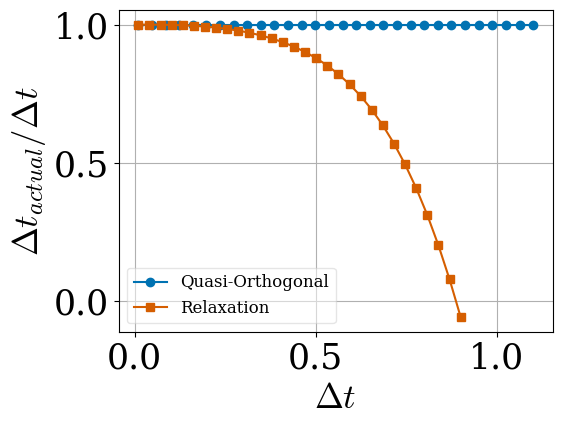

In [9]:
dts_r = np.linspace(0.01, 0.9,30)
dts_qo= np.linspace(0.01, 1.1,30)

u0= FR_SV
f= Energy_decay_f

A= np.array([[-1, -2, -2], [0, -1, -2], [0,0,-1]])
tf= 2
t0=0

gamma_r = np.zeros(len(dts_r))


for dt_idx in range(len(dts_r)):
    dt = dts_r[dt_idx]
        #b_T, b_U = compute_sol_without_relaxation(method_names[idx], rkm, dt, f, tf, u0, t0)
    r_T, r_U, Gamma,  Inv1_change = compute_relaxation("rk4",rk44, dt, f, tf, u0, t0, n_lim=1)
        
       
    gamma_r[dt_idx]=Gamma[0]; 



fig = plt.figure(1)

plt.plot(dts_qo, np.ones(len(dts_qo)), '-o',color= colors[3],label = "Quasi-Orthogonal")
plt.plot(dts_r, gamma_r+1, '-s', color= colors[4],label = "Relaxation")
#plt.plot([0, 1], [0,0])

plt.xlabel("$\Delta t$"); plt.ylabel("$\Delta t_{actual}/\Delta t$")
fig.tight_layout()
plt.legend(fontsize=12)

plt.grid()

#plt.savefig("Figures/Lin_energy_decay.png")

plt.show()

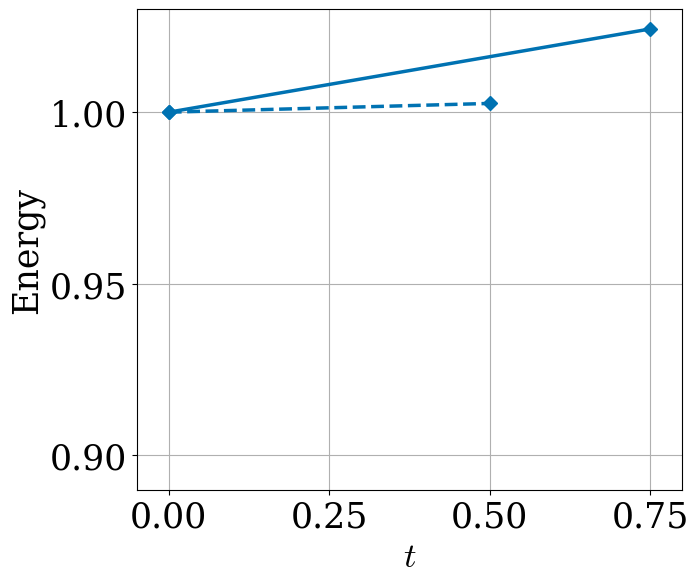

<Figure size 640x480 with 0 Axes>

In [10]:
u0= FR_SV

A= np.array([[-1, -2, -2], [0, -1, -2], [0,0,-1]])

dt= 0.5
t=[]

#dts= np.array([0.5, 0.7])
t_final= 1.0
T= t_final
t0=0

base= rk44

lw=2.5 


tt, uu= compute_sol_without_relaxation("rk4",rk44, 0.5, f, T, u0, t0, n_lim=1)

E = (uu**2).sum(1)
plt.plot(tt, E, color=colors[3] , linestyle=linestyles[1],marker=markers[1],markersize=7,lw=lw, label='$\Delta t=0.5$')


tt, uu= compute_sol_without_relaxation("rk4",rk44, 0.75, f, T, u0, t0, n_lim=1)
E = (uu**2).sum(1)
plt.plot(tt, E, color=colors[3] , linestyle=linestyles[0],marker=markers[1],markersize=7, lw=lw, label='$\Delta t=0.75$')


plt.xlabel("$t$", fontsize= 25)
#plt.ylabel( "$||q(t)||_2^2$", fontsize= 25)
plt.ylabel( "Energy", fontsize= 25)
#plt.title('Relaxation Free-RK methods' , fontsize= 18)

ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1.1, box.height*1.3])


plt.grid()

plt.ylim([0.89,1.03])
plt.xticks([0,0.25, 0.5,0.75])
plt.xlim([-0.05, 0.8])
plt.yticks([0.9, 0.95,1])

#plt.savefig("Figures/Lin_decay_RK.png",bbox_inches="tight")

ax = plt.gca()
plt.figure()
handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc="center", ncol=4)
#plt.savefig("./Figures/Lin_Energy_decay_legend.png", bbox_inches="tight")


plt.show()


[0.         0.36350354]


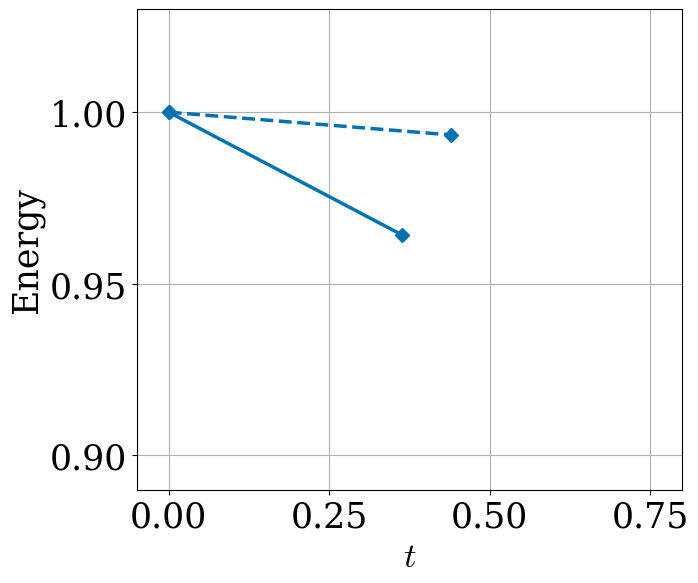

In [11]:
tt, uu, Gamma,  Inv1_change = compute_relaxation("rk4",rk44, 0.5, f, T, u0, t0, n_lim=1)
E = (uu**2).sum(1)
plt.plot(tt, E, color=colors[3] , linestyle=linestyles[1],marker=markers[1],markersize=7,lw=lw, label='R-RK(4,4),   $\Delta t=0.5$')
print(tt)


tt, uu, Gamma,  Inv1_change = compute_relaxation("rk4",rk44, 0.75, f, T, u0, t0, n_lim=1)
E = (uu**2).sum(1)
plt.plot(tt, E, color=colors[3] , linestyle=linestyles[0],marker=markers[1],markersize=7 ,lw=lw, label='R-RK(4,4),   $\Delta t=0.7$')
print(tt)

plt.xlabel("$t$", fontsize= 25)
#plt.ylabel("$||q(t)||_2^2$", fontsize= 25)
plt.ylabel( "Energy", fontsize= 25)
#plt.title('Relaxation Free-RK methods' , fontsize= 18)

ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1.1, box.height*1.3])


plt.grid()

plt.ylim([0.89,1.03])
plt.xlim([-0.05, 0.8])
plt.xticks([0,0.25, 0.5,0.75])
plt.yticks([0.9, 0.95,1])

#plt.savefig("Figures/Lin_decay_RRK.png",bbox_inches="tight")
plt.show()

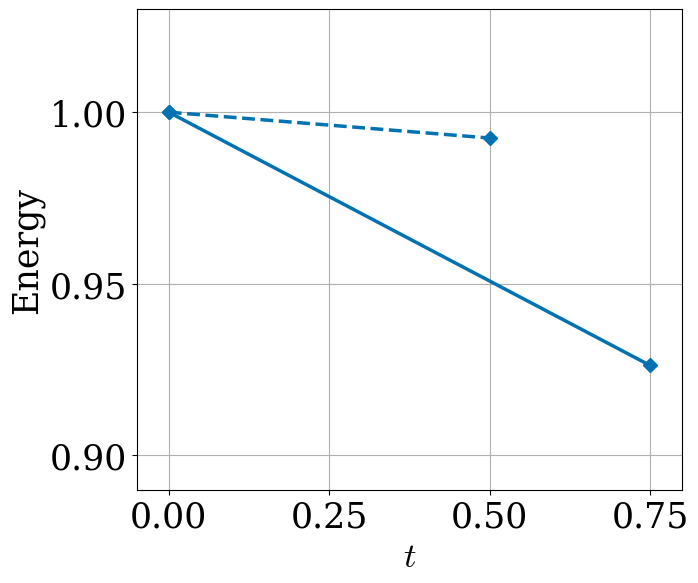

In [12]:
tt, uu, Eps_qo,  Inv1_change= compute_sol_QO("rk4",rk44, 0.5, f, T, u0, t0, n_lim=1)
E = (uu**2).sum(1)
plt.plot(tt, E, color=colors[3] ,linestyle= linestyles[1],marker=markers[1],markersize=7 ,lw=lw, label='QO-RK(4,4), $\Delta t=0.5$')



tt, uu, Eps_qo,  Inv1_change= compute_sol_QO("rk4",rk44, 0.75, f, T, u0, t0, n_lim=1)
E = (uu**2).sum(1)
plt.plot(tt, E, color=colors[3] ,linestyle=linestyles[0],marker=markers[1],markersize=7 ,lw=lw, label='QO-RK(4,4), $\Delta t=0.7$')


plt.xlabel("$t$", fontsize= 25)
#plt.ylabel("$||q(t)||_2^2$", fontsize= 25)
plt.ylabel( "Energy", fontsize= 25)
#plt.title('Relaxation Free-RK methods' , fontsize= 18)

ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1.1, box.height*1.3])


plt.grid()

plt.ylim([0.89,1.03])
plt.xlim([-0.05, 0.8])
plt.xticks([0,0.25, 0.5,0.75])
plt.yticks([0.9, 0.95,1])

#plt.savefig("Figures/Lin_decay_QORK.png",bbox_inches="tight")
plt.show()


# Order of accuracy

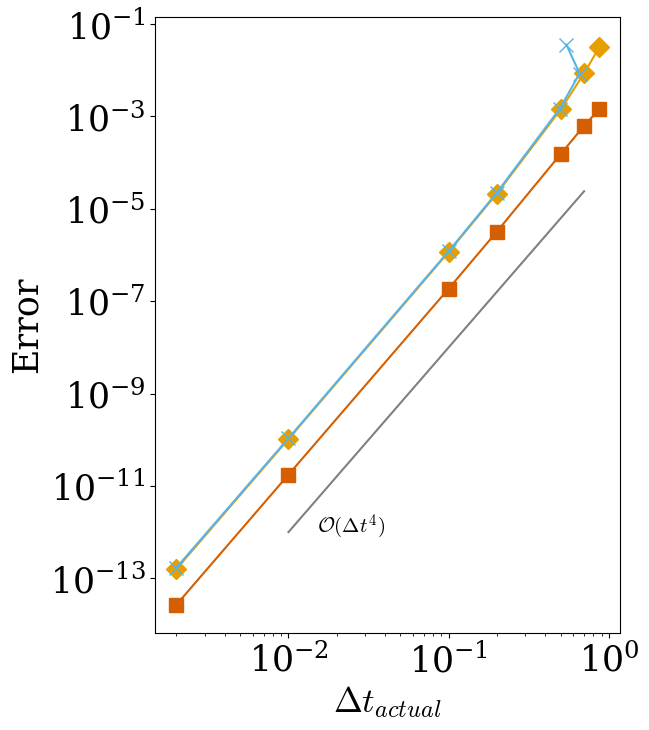

<Figure size 640x480 with 0 Axes>

In [13]:


fig=plt.figure(figsize=(6,8))
#ax = plt.subplot(111)


dts= np.array([ 0.002,  0.01, 0.1, 0.2, 0.5, 0.7 , 0.87])

markers = ['s','D','x','s','v',"P"]


linestyles = [':','-', '--',  '-.', (5, (10, 3)),(0, (3, 1, 1, 1))]

colors = ['#D55E00','#E69F00', '#56B4E9', '#CC79A7', '#F0E442']






t_final=5




#calculating the solutions


rk_errors= np.zeros( dts.size)
qo_errors= np.zeros( dts.size)
rrk_errors= np.zeros(dts.size)

err_rk= np.zeros((dts.size))
err_qo= np.zeros((dts.size,))
err_rrk= np.zeros((dts.size))

dts_rrk= np.zeros(dts.size)

dt_ref= 0.001
tt, uu_rk= compute_sol_without_relaxation("rk4",rk44, dt_ref, f, t_final, u0, t0=0, n_lim= 1e9)
ref= uu_rk[-1,:]


for i, dt in enumerate(dts):
    
    tt, uu_rk= compute_sol_without_relaxation("rk4",rk44, dt, f, t_final, u0, t0=0, n_lim= 1e9)
    tt, uu_rrk, Gamma,  Inv1_change = compute_relaxation("rk4",rk44, dt, f, t_final, u0, t0=0, n_lim= 1e9)
    dts_rrk[i]= dt* (1+ np.average(Gamma))
    
    tt, uu_qo, Eps_qo,  Inv1_change= compute_sol_QO("rk4",rk44, dt, f, t_final, u0, t0, n_lim= 1e9)

    err_rk[i]= np.sum(np.abs(ref - uu_rk[-1,:]))
    err_qo[i]= np.sum(np.abs(ref - uu_qo[-1,:]))
    err_rrk[i]= np.sum(np.abs(ref - uu_rrk[-1,:]))




    
    
   


plt.loglog(dts, err_rk, linestyle='-',color=colors[0],marker=markers[0],markersize=10, label='Base RK' )
plt.loglog(dts, err_qo, linestyle='-',color=colors[1],marker=markers[1],markersize=10, label='Quasi-Orthogonal' )
plt.loglog(dts_rrk, err_rrk, linestyle='-',color=colors[2],marker=markers[2],markersize=10, label='Relaxation' )


# -------------------------------------------------------------




#cfl_ind= np.array([0.03, 0.2])
plt.loglog(dts[1:-1],0.0001* dts[1:-1]**4, color= 'gray')
plt.annotate(r"$\mathcal{O}(\Delta t^4)$", (1.5e-2, 1e-12), color="k", fontsize=15)




plt.xlabel("$\Delta t_{actual}$")
plt.ylabel('Error')





#plt.savefig("Figures/Lin_decay_convergence.png",bbox_inches="tight")


ax = plt.gca()
plt.figure()
handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc="center", ncol=3)
#plt.savefig("./Figures/Lin_decay_convergence_legend.png",bbox_inches="tight")


plt.show()